In [31]:
pip install -e "git+https://github.com/r-trimbour/atac-networks.git#egg=atac-networks"

Obtaining atac-networks from git+https://github.com/r-trimbour/atac-networks.git#egg=atac-networks
  Updating ./src/atac-networks clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 268b9bd6643b34aab6dfca2ea835caf1bdca9e94
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: atac-networks
    Found existing installation: atac-networks 0.1.0
    Can't uninstall 'atac-networks'. No files were found to uninstall.
  Running setup.py develop for atac-networks
Note: you may need to restart the kernel to use updated packages.


In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=r".*Reordering categories will always return a new Categorical object.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=r".*is_categorical_dtype is deprecated and will be removed in a future version.*")

In [2]:
import atac_networks as an
import atac_networks.metacells
import scanpy as sc

In [3]:
?atac_networks.add_region_infos

Signature: atac_networks.add_region_infos(AnnData, sep=('_', '_'), inplace=True)
Docstring:
Get region informations from the var_names of AnnData object.
e.g. chr1_12345_12346 -> 'chromosome' : chr1,
                         'start' : 12345,
                         'end' : 12346
These info will be added to var of AnnData object.
    adata.var['chromosome'] : chromosome
    adata.var['start'] : start position
    adata.var['end'] : end position

Parameters
----------
AnnData : AnnData object
    AnnData object with var_names as region names.
sep : tuple, optional
    Separator of region names. The default is ('_', '_').

Returns
-------
AnnData : AnnData object
    AnnData object with region informations in var.
File:      ~/ATACNet/atac_network/atac_networks/atac_networks.py
Type:      function

In [4]:
import numpy as np
import pandas as pd
import anndata as ad

import scipy as sp
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
import matplotlib.pyplot as plt

# Test with sparse covariance true matrix as GT

### 0. Create fake AnnData

In [5]:
# Create fake single-cell atac-seq data
nb_cells = 300
nb_chr = 10
nb_regions_per_chr = 200
between_reg = 2000
size_reg = 50

counts = []
for chr in range(nb_chr):
    counts.append(pd.DataFrame(np.random.randint(0,100, size=(nb_cells, nb_regions_per_chr)),
                        index=['Cell_'+j for j in map(str, range(nb_cells))],
                        columns=['chr'+str(chr)+'_'+str(i)+'_'+str(i+size_reg) for i in range(1, nb_regions_per_chr*between_reg+1, between_reg)]))
atac = ad.AnnData(pd.concat(counts, axis=1))

In [6]:
distance_threshold = 50000

### 1. Add region position in AnnData.obs

In [7]:
atac_networks.add_region_infos(atac)

### 2. Replace random data with fake cov matrix

In [8]:
n_samples, n_features = 300, nb_regions_per_chr

prng = np.random.RandomState(0)
prec = make_sparse_spd_matrix(
    n_features, alpha=0.99, smallest_coef=0.4, largest_coef=0.7, random_state=prng
)
cov = linalg.inv(prec)

#cov with only potential connections
possible_co = sp.sparse.csr_matrix(atac_networks.get_distances_regions(atac)<distance_threshold/2)[:cov.shape[0],:cov.shape[1]]
possible_co = sp.sparse.coo_matrix(possible_co).toarray() + sp.sparse.coo_matrix(possible_co).toarray().T 
cov = np.eye(len(cov))*np.diag(cov) + possible_co*cov 
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
X -= X.mean(axis=0)
X /= X.std(axis=0)

X_ = np.concatenate([X]*nb_chr, axis=1)
atac.X = np.abs(X_)
atac.X = np.where(X_<0, 0, X_)

### 2.A. Remove Null rows

In [9]:
sc.pp.filter_genes(atac, min_cells=1)
atac

AnnData object with n_obs × n_vars = 300 × 2000
    var: 'chromosome', 'start', 'end', 'n_cells'

### 2.B. Compute pseudocells

In [10]:
metacells = an.metacells.compute_metacells(atac)
an.add_region_infos(metacells)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 12038.60it/s]


### 3 Calculate co-accessibility

In [12]:
an.compute_atac_network(
    atac,
    window_size=distance_threshold,
    unit_distance = 1000,
    distance_constraint=distance_threshold/2,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=60
)

Calculating penalty coefficient alpha...


 21%|███████████████████████████████▋                                                                                                                       | 21/100 [00:00<00:01, 62.74it/s]

maximum number of iterations hit
maximum number of iterations hit


 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 46/100 [00:00<00:00, 75.14it/s]

maximum number of iterations hit


 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 57/100 [00:00<00:00, 67.33it/s]


Calculating co-accessibility scores...
Starting to process chromosomes : ['chr0' 'chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 57.14it/s]


Finishing to process chromosomes : ['chr0' 'chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 82.39it/s]


Averaging co-accessibility scores across windows...
Done !


*Can be stored externally using sliding_graphica_lasso*

In [13]:
final_score = an.sliding_graphical_lasso(
    metacells,
    window_size=distance_threshold,
    unit_distance = 1000,
    distance_constraint=distance_threshold/2,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=60
)
metacells.varp['atac_network'] = final_score

Calculating penalty coefficient alpha...


  0%|                                                                                                                                                                | 0/100 [00:00<?, ?it/s]

maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit


  6%|█████████                                                                                                                                               | 6/100 [00:00<00:01, 50.84it/s]

maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit


 12%|██████████████████                                                                                                                                     | 12/100 [00:00<00:01, 51.51it/s]

maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit


 18%|███████████████████████████▏                                                                                                                           | 18/100 [00:00<00:01, 51.54it/s]

maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit


 25%|█████████████████████████████████████▊                                                                                                                 | 25/100 [00:00<00:01, 54.35it/s]

maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit


 31%|██████████████████████████████████████████████▊                                                                                                        | 31/100 [00:00<00:01, 56.01it/s]

maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit


 37%|███████████████████████████████████████████████████████▊                                                                                               | 37/100 [00:00<00:01, 50.39it/s]

maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit


 43%|████████████████████████████████████████████████████████████████▉                                                                                      | 43/100 [00:00<00:01, 51.38it/s]

maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit


 49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 49/100 [00:00<00:01, 49.75it/s]

maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit
maximum number of iterations hit


 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 54/100 [00:01<00:00, 50.91it/s]


maximum number of iterations hit
Calculating co-accessibility scores...
Starting to process chromosomes : ['chr0' 'chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 85.52it/s]


Finishing to process chromosomes : ['chr0' 'chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 69.81it/s]

Averaging co-accessibility scores across windows...
Done !


### 3. B. Extract list of edges

In [16]:
an.extract_atac_links(metacells)

,Peak1,Peak2,score
5180,chr2_280001_280051,chr2_282001_282051,0.007679
16496,chr8_280001_280051,chr8_282001_282051,0.007679
10838,chr5_280001_280051,chr5_282001_282051,0.007679
1408,chr0_280001_280051,chr0_282001_282051,0.007679
8952,chr4_280001_280051,chr4_282001_282051,0.007679
...,...,...,...
1316,chr0_254001_254051,chr0_264001_264051,-0.015913
12632,chr6_254001_254051,chr6_264001_264051,-0.015913
5088,chr2_254001_254051,chr2_264001_264051,-0.015913
6974,chr3_254001_254051,chr3_264001_264051,-0.015913


In [17]:
an.extract_atac_links(atac)

,Peak1,Peak2,score
9863,chr3_6001_6051,chr3_30001_30051,0.070242
16385,chr5_6001_6051,chr5_30001_30051,0.070242
22907,chr7_6001_6051,chr7_30001_30051,0.070242
26168,chr8_6001_6051,chr8_30001_30051,0.070242
13124,chr4_6001_6051,chr4_30001_30051,0.070242
...,...,...,...
27571,chr8_168001_168051,chr8_184001_184051,-0.030701
14527,chr4_168001_168051,chr4_184001_184051,-0.030701
30832,chr9_168001_168051,chr9_184001_184051,-0.030701
8005,chr2_168001_168051,chr2_184001_184051,-0.030701


### 4. Plot comparison between co-accessibility scores and covariance matrix used to generate the data

0.4475 0.215


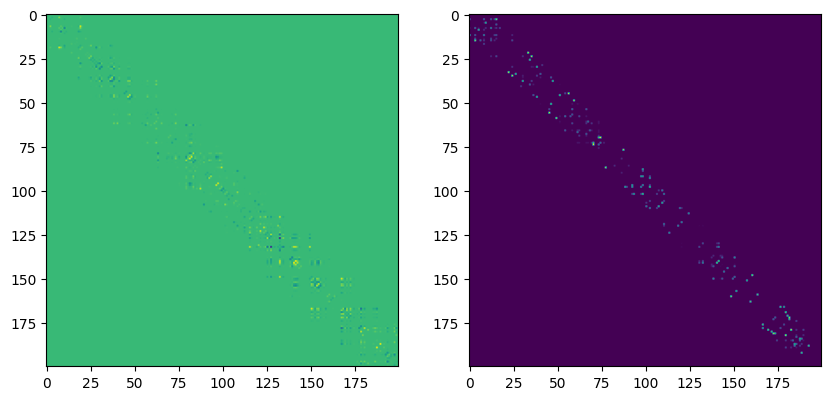

In [18]:
def diag_block_mat_slicing(L):
    shp = L[0].shape
    N = len(L)
    r = range(N)
    out = np.zeros((N,shp[0],N,shp[1]),dtype=int)
    out[r,:,r,:] = L
    return out.reshape(np.asarray(shp)*N)

corrected = final_score.toarray()[:200, :200]
corrected = np.where(corrected <= 0, corrected, corrected)
corrected = corrected - np.diag(corrected)*np.eye(len(cov))

cov_ = cov - np.diag(cov)*np.eye(len(cov))

fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(corrected)
ax[1].imshow(np.where(cov_<=0, cov_, cov_))


print((cov_[:20,:20]>0).sum()/(400), (corrected[:20,:20]>0).sum()/(400), )

0.53 0.01


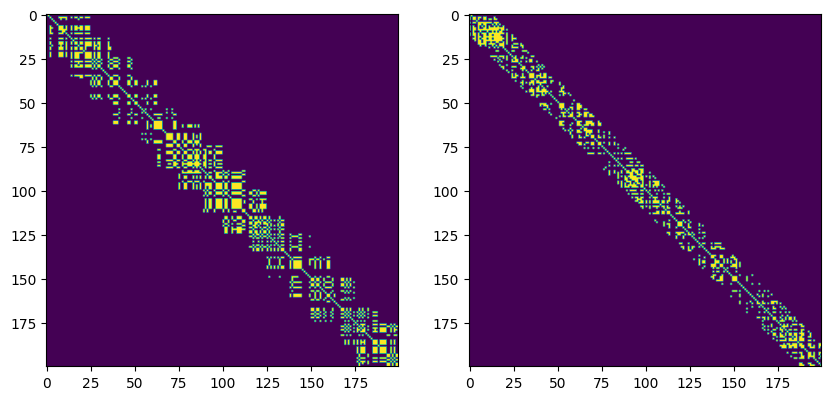

In [19]:
corrected = final_score.toarray()[:200, :200]
corrected = np.where(corrected <= 0, 0, 1)


fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(corrected)
ax[1].imshow(np.where(cov<=0, 0, 1))

print((cov[:10,:10]>0).sum()/(100), (corrected[10,10]>0).sum()/(100), )